In [ ]:
# 1.1. Генерация данных
# загрузите и визуализируйте данные https://github.com/VisDrone/VisDrone-Dataset выполните генерацию данных.
# Для генерации данныхт Вам потребуется:
# - выделить участки "фона" (участки, базового изображения). На базовом изображении возможно наличие объектов базового датасета.
# ---- информация об объектах должна быть сохранена.
# - выделить участки объектов(участки bbox разметки). Можете ограничиться одним типом объектов, например, автомобилями.

# Для склейки и изображений друг с другом применять: https://learnopencv.com/seamless-cloning-using-opencv-python-cpp/

# Основные этапы генерации:
# 1. Формирование(комбинирование) фона из набора патчей для формирования фона из набора патчей.
# ---- Для формирования фона использовать сетку 2*2, в каждой йчейке фона - собственное фоновое изображение.
# ---- Выбор фонового изображения каждой ячейки сетки производится случайным образом.
# 2. Наложение объектов. Выбор метоположения, вариации масштабирования,и тп. - случайный.
# ---- Возможно перекрытие объектов, c долей перекрытия уже расзмещенного объекта  - не более 50%.
# 3. Генератор возвращает: исходное изображение, набор bbox элементов, количество объектов на изображении.

# 1.2. Препроцессинг патчей перед наложением цвета.
# Препроцессинг патча перед наложением.
# Добавьте возможность статистической цветокоррекции любого патча на основе статистики любого патча из класса.
# ---- Например, происходит наложениеи патча_1 объекта.
# ---- Перед наложением патча, выполнить его статистическую цветокоррекцию на основе патча_2(выбранного из данных с объектами).


# 1.3. Визуализация данных.
# Для демонстрации работы генератора визуализировать: 
# ---- исходное изображение
# ---- изображение с отрисованными объектами
# ---- количество объектов
# ---- гистограмму изображения

Для создания пользовательского датасета class должен переопределить следующие методы: 
def __init__(self, param1, param2, param3...):
 вызывается один раз при создании объекта класса-наследника Dataset object. Сохраняются директории-пути к файлам и аннотациям, методы аугмпентации  пользовательских данных. 
def __len__(self):
Возвращаеет Количество экземпляров выборки в пользовательском датасете
def __getitem__(self, idx):
Загружает и возвращает экзмляр данных по индексу idx

In [34]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.transforms as v2
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=v2.ToTensor())
)

SyntaxError: unmatched ')' (1338594897.py, line 13)

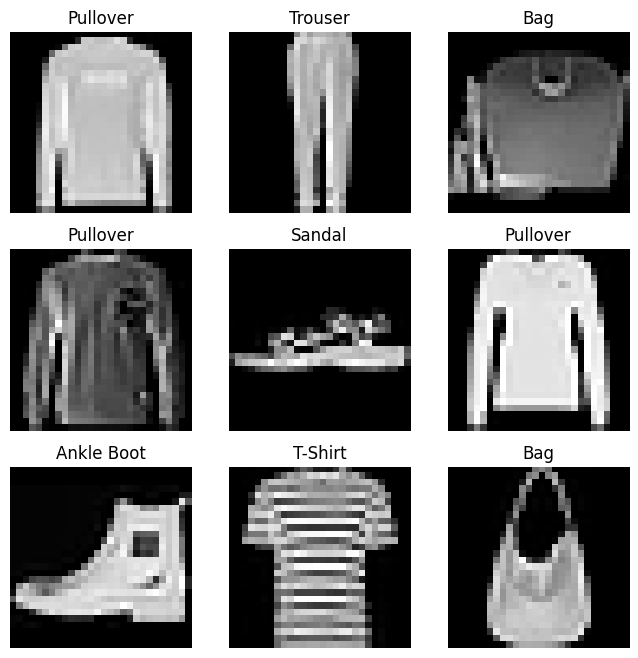

In [35]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()


In [124]:
from __future__ import annotations

import numpy as np
import cv2
import copy
from typing import Tuple
import random
import torch
from torch.utils.data import Dataset

class ChessBoardWildFashionDataset(Dataset):
    """Chess board dataset with MNIST squares as defects"""

    def __init__(
        self,
        img_size: Tuple[int, int],
        patch_size: Tuple[int, int],
        dataset_size: int,
        noise_dataset: Dataset,  # "mnist"
    ):
        self.image_size = img_size
        self.ps = patch_size
        self.img_base = np.zeros((self.ps[0] * 8, self.ps[1] * 8, 3), dtype=np.uint8)
        self.dataset_size = dataset_size
        self.noise_images = noise_dataset

        for i in range(8):
            for j in range(8):
                if (i + j) % 2 == 0:
                    self.img_base[i * self.ps[0] : (i + 1) * self.ps[0], j * self.ps[1] : (j + 1) * self.ps[1], :] = (
                        np.ones((self.ps[0], self.ps[1], 3), dtype=np.uint8) * 255
                    )

    def __len__(self):
        return self.dataset_size

    def __getitem__(self, item: int) -> Tuple[torch.Tensor, torch.Tensor]:  # image, 17-class target 1:
        img = copy.deepcopy(self.img_base)

        count = random.randint(0, 11)  # count of defects

        # label list
        # [0] - 0/1 - not rejected/rejected image
        # [1:17] - 0/1 - note defected/defected image patch
        labels = [0 for n in range(17)]
        plus_i = 1

        # if defect count > 5, the image is rejected
        if count > 5:
            labels[0] = 1
        for i in range(count):
            # randomly choose defect image from noise dataset
            img_num,_ = self.noise_images[random.randint(0, len(self.noise_images) - 1)]
            img_num = v2.Resize((32,32))(img_num)*2
            img_num = np.repeat(np.reshape(img_num.numpy(), (32,32,1)),3,axis = 2)

            # randomly choose defect location
            i = random.randint(0, 7)
            j = random.randint(0, 7)

            idx = i // 2 * 4 + j // 2
            labels[idx + plus_i] = 1

            img[i * self.ps[0] : (i + 1) * self.ps[0], j * self.ps[1] : (j + 1) * self.ps[1], :] = img_num

        img = cv2.resize(img, dsize=(self.image_size[0], self.image_size[1]))
        img = img.astype(float)
        #img /= 255  # normalize data
        
        return (
            torch.FloatTensor(img),
            sum(labels[1:]),
        )

In [125]:
cbwf_dataset =  ChessBoardWildFashionDataset((256,256),(32,32),32, training_data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB dat

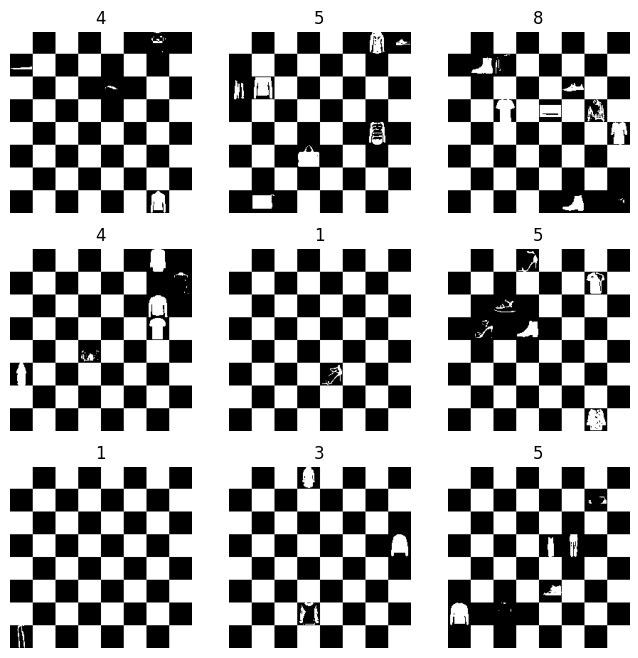

In [126]:
labels_map = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5',
    6: '6',
    7: '7',
    8: '8',
    9: '9',
    10: '10',
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(cbwf_dataset), size=(1,)).item()
    img, label = cbwf_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()